# Imports

In [48]:

import copy
import glob
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd
import random
import time
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchsummary import summary
from torchvision import datasets
from torchvision.models import resnet50
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler




%matplotlib inline
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Parametros Treinamento

In [49]:
args = {
    'epoch_num': 4,
    'lr': 1e-3,
    'weight_decay':5e-4,
    'batch_size': 8,
    'classes': 3,

}


transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Ajustar o tamanho da imagem para o tamanho esperado pelo ResNet (224x224)
    transforms.CenterCrop(224),
    transforms.RandomRotation(3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])


args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(args['device'])

cuda


# Import Dataset (Mude os caminhos)

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



dataset = datasets.ImageFolder("/content/drive/MyDrive/latinScience/CRD", transform=transform)

classes = [key for key, value in sorted(dataset.class_to_idx.items(), key=lambda item: item[1])]
print(classes)

"""

# 1. Identificar o número de casos na classe com o menor número de exemplos
class_counts = {}
for _, label in dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

min_class_count = min(class_counts.values())

# 2. Realizar undersampling nas duas maiores classes
indices_to_keep = []

for class_label, count in class_counts.items():
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    if count > min_class_count and class_label in sorted(class_counts, key=class_counts.get, reverse=True)[:2]:
        class_indices = random.sample(class_indices, min_class_count)
    indices_to_keep.extend(class_indices)

# 3. Criar um novo conjunto de dados balanceado
dataset = Subset(dataset, indices_to_keep)
"""


# Dividir o conjunto de dados em treinamento e teste
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=args['batch_size'])



Mounted at /content/drive
['BND', 'COVID', 'Normal']


# Visualiza exemplares

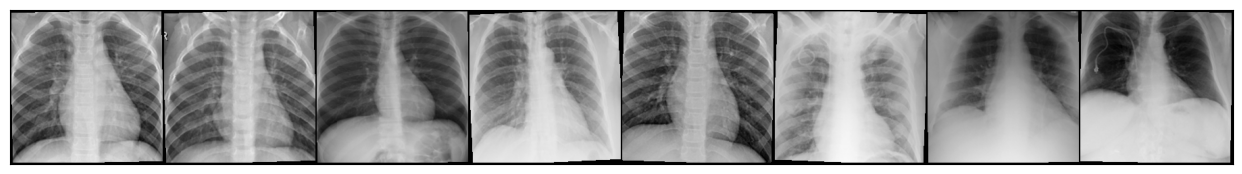

In [51]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 2))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(test_loader)

# Importa Modelo

In [52]:
modelo = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
modelo.fc = nn.Linear(in_features=2048, out_features=args['classes'], bias=True)


modelo.to(args['device'])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train

In [53]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(modelo.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

def train(train_loader, net, epoch):
  net.train()
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    dado, rotulo = batch
    if dado.size(0) == 0 or rotulo.size(0) == 0:
      continue
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_array = np.concatenate(pred_list)
  rotulo_array = np.concatenate(rotulo_list)
  acc = accuracy_score(pred_array, rotulo_array)
  print('Epochs: %d, Loss: %.4f +/- %.4f, Acc: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100))
  return acc


train(train_loader=train_loader, net=modelo,epoch=args['epoch_num'])

Epochs: 4, Loss: 1.0791 +/- 0.2099, Acc: 42.43


0.4243382062425919

# Teste

              precision    recall  f1-score   support

           0       0.41      0.35      0.38       773
           1       0.45      0.90      0.60       690
           2       0.45      0.09      0.14       707

    accuracy                           0.44      2170
   macro avg       0.44      0.45      0.37      2170
weighted avg       0.44      0.44      0.37      2170



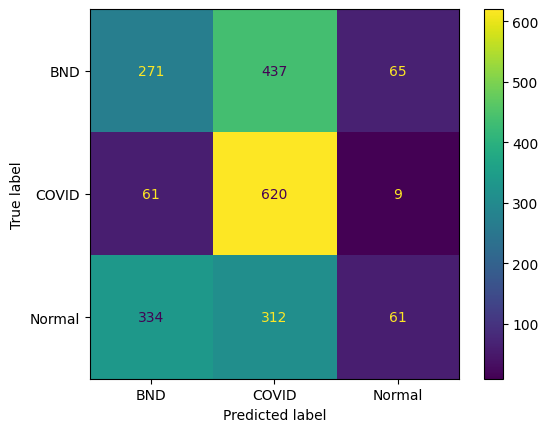

In [54]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(args['device'])
            labels = labels.to(args['device'])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


test_preds, test_labels = evaluate_model(modelo, test_loader)

conf_matrix = confusion_matrix(test_labels, test_preds)

f1 = f1_score(test_labels, test_preds,average='macro')

acc = accuracy_score(test_labels, test_preds)
print(classification_report(test_labels, test_preds))
confusion_display = ConfusionMatrixDisplay(conf_matrix,display_labels=classes).plot()


# Finaliza experimento MLflow

In [55]:
#torch.save(modelo, '/content/drive/MyDrive/latinScience/saved_models/resnet_CRD.pth')